In [1]:
import pickle
import os
import cv2
import numpy as np
import PIL
import torch
#PIL.PILLOW_VERSION = PIL.__version__

from src.dataset import VDAODataset
from torch.utils.data import DataLoader
from src import RESULT_DIR
from src.utils import MCC, DIS, conf_mat
import matplotlib.pyplot as plt
import pandas as pd

from scripts.extra.mcDTSR.utils.srmc_outer_repr import srmc_outer_repr




/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /nfs/home/luiz.tavares/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE
  warn(f"Failed to load image Python extension: {e}")


### Reference and target examples

In [3]:
out_dir = os.path.join(RESULT_DIR, 'img_results', 'paper')

fold = -1
num_frames = 201
dataset = VDAODataset(fold = fold, split = 0, type = 'test',
                      alignment = 'temporal', transform = False)
dd = dataset.align_df
vid_list = dd.test_file.unique()
loader = DataLoader(dataset, num_workers=8, batch_size=1, shuffle=False)
ref_frame, tar_frame, sil_frame , _   = dataset.__getitem__(100)
w, h = ref_frame.shape[1], ref_frame.shape[0]

ref_frame = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB)
tar_frame = cv2.cvtColor(tar_frame, cv2.COLOR_BGR2RGB)
sil_frame = cv2.cvtColor((255*sil_frame).astype(np.uint8), cv2.COLOR_GRAY2BGR)

plt.imshow(tar_frame)

FileNotFoundError: [Errno 2] No such file or directory: '/home/luiz.tavares/Workspace/VDAO_Pixel/data/alignment/geometric_test_fold-1.csv'

In [72]:
cv2.imwrite(os.path.join(out_dir, 'ref_img.png'), ref_frame)
cv2.imwrite(os.path.join(out_dir, 'tar_img.png'), tar_frame)
cv2.imwrite(os.path.join(out_dir, 'sil_img.png'), sil_frame)

True

### Tunnel plotting

In [3]:
from src.utils import threshold, opening, closing, voting_window

silhouette_file = os.path.join(RESULT_DIR, 'test_results', 'silhouette.pkl')
sil_tensor = pickle.load(open(silhouette_file, 'rb'))

out_file = os.path.join(RESULT_DIR, 'test_results', 'LightGBM_warp.pkl')
out_tensor = pickle.load(open(out_file, 'rb'))

params_file = os.path.join(RESULT_DIR, 'hyperparameter_search.pkl')

def frames_last(tensor):
    return np.swapaxes(tensor.copy(), 1, 2).T

def upsample(tensor):
    return cv2.resize(tensor, dsize=(1280, 720), interpolation=cv2.INTER_LINEAR)

In [12]:
fold = 4
vid_idx = 0

video_keys = list(sil_tensor[fold].keys())
sil_video = video_keys[vid_idx]

sil = frames_last(sil_tensor[fold][sil_video])
out = out_tensor[fold][sil_video]
params = pickle.load(open(params_file, 'rb'))['LightGBM']['warp'][fold]


print('Selecting video {0} from fold {1}'.format(sil_video, fold))

Selecting video 5 from fold 4


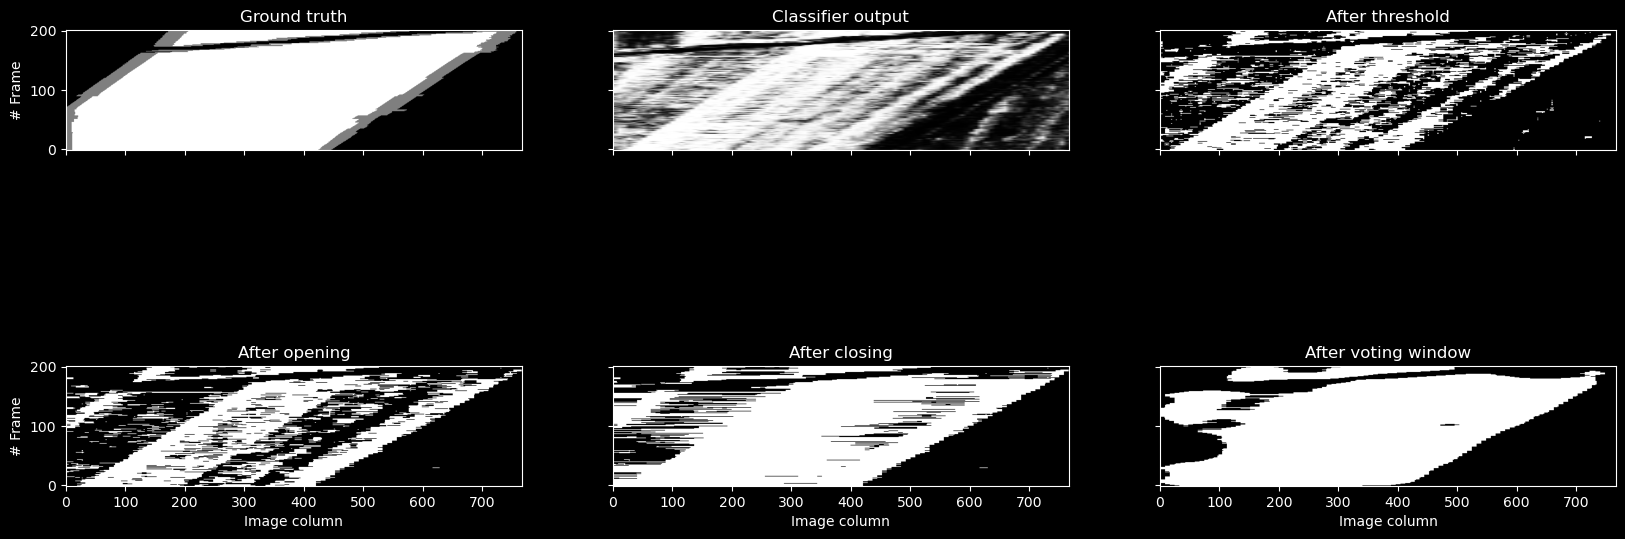

In [13]:
# Finding baricenter
mass_x, mass_y, mass_z = np.where(sil >= 200)
cent_x = int(np.average(mass_x))

sil_profile = sil[cent_x, :, :].T
x_max = min(np.max(np.where(sil_profile.sum(axis=0)>0))+10, 1280)
x_min = max(np.min(np.where(sil_profile.sum(axis=0)>0))-10, 0)

out_post = threshold(torch.Tensor(out), params['threshold_post'])
out_open = opening(out_post, params['opening'])
out_close = closing(out_open, params['closing'])
vid_out = voting_window(out_close,
                        (params['voting_depth'],
                         params['voting_width'],
                         params['voting_width']),
                        params['count']/100)


out_prob_sup = upsample(frames_last(out))
out_prob_sup = out_prob_sup[cent_x, :, :].T
out_post_sup = upsample(frames_last(out_post))
out_post_sup = out_post_sup[cent_x, :, :].T
out_open_sup = upsample(frames_last(out_open))
out_open_sup = out_open_sup[cent_x, :, :].T
out_close_sup = upsample(frames_last(out_close))
out_close_sup = out_close_sup[cent_x, :, :].T
out_vw_sup = upsample(frames_last(vid_out))
out_vw_sup = out_vw_sup[cent_x, :, :].T

fig_w = out_prob_sup.shape[1] // 100
fig_h = 200 // 100

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 8))

ax[0, 0].imshow(sil_profile, cmap='gray', origin='lower')
ax[0, 1].imshow(out_prob_sup, cmap='gray', origin='lower')
ax[0, 2].imshow(out_post_sup, cmap='gray', origin='lower')
ax[1, 0].imshow(out_open_sup, cmap='gray', origin='lower')
ax[1, 1].imshow(out_close_sup, cmap='gray', origin='lower')
ax[1, 2].imshow(out_vw_sup, cmap='gray', origin='lower')

ax[0, 0].set_title('Ground truth')
ax[0, 1].set_title('Classifier output')
ax[0, 2].set_title('After threshold')
ax[1, 0].set_title('After opening')
ax[1, 1].set_title('After closing')
ax[1, 2].set_title('After voting window')

ax[0, 0].set_ylabel('# Frame')
ax[1, 0].set_ylabel('# Frame')
ax[1, 0].set_xlabel('Image column')
ax[1, 1].set_xlabel('Image column')
ax[1, 2].set_xlabel('Image column')

for aa in ax:
    for a in aa:
        a.set_xlim(x_min, x_max)
fig.show()

In [ ]:
contours, hierarchy = cv2.findContours(out_vw_sup, cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
sil_profile_clr = cv2.cvtColor(sil_profile, cv2.COLOR_GRAY2RGB)                              
cv2.drawContours(sil_profile_clr, contours, -1, (255,0,0), 1, line_)

plt.imshow(sil_profile_clr, origin='lower')
plt.xlim(x_min, x_max)
plt.show()